<a href="https://colab.research.google.com/github/selimboukabara/selimboukabara.github.io/blob/master/PolySub_Project_1st_research_question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initialize Dataframe

In [3]:
#Start with 405 participants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_UDS = pd.read_excel('combined.xlsx')
df_UDS.dropna(inplace=True)

In [5]:
#One-Hot Encode
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
df_UDS["doctor treating"] = df_UDS["doctor treating"].str.upper()
categorical_features = ['Gender', 'Race', 'Ethnic_Group', 'eGFR_D1', 'Bilirubin_Total_D1','SMHQ_SmokingStatus','SCID_Version', 'doctor treating']
ct = ColumnTransformer([('OneHot', OneHotEncoder(), categorical_features)], remainder='passthrough')
df_UDS_numbers = pd.DataFrame(ct.fit_transform(df_UDS))
categorical_transformer = Pipeline(steps=[('OneHot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)],remainder='passthrough')
pipeline = Pipeline(steps=[('preprocessor', preprocessor),])
X_transformed = pipeline.fit_transform(df_UDS)
transformed_column_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['OneHot'].get_feature_names_out(categorical_features)
all_column_names = list(transformed_column_names) + [col for col in df_UDS.columns if col not in categorical_features]
df = pd.DataFrame(X_transformed, columns=all_column_names)

In [6]:
#Convert to Input and Output
X_UDS = df.iloc[:,106:108]
X_SUD = df.iloc[:,108:110]
X_Control = df.iloc[:,0:106]
X_UDS_Control = X_Control.join(X_UDS)
X_SUD_Control = X_Control.join(X_SUD)
y = df.iloc[:,110:111]

In [7]:
#Subset to CIWA
df_UDS = pd.DataFrame(df_UDS)
CIWA5 = df[(df["max CIWA score"] > 5)]
CIWA10 = df[(df["max CIWA score"] > 10)]
y_CIWA5 = y.iloc[CIWA5.index, :]
y_CIWA10 = y.iloc[CIWA10.index, :]
X_UDS_CIWA5 = X_UDS_Control.iloc[CIWA5.index, :]
X_UDS_CIWA10 = X_UDS_Control.iloc[CIWA10.index, :]
X_SUD_CIWA5 = X_SUD_Control.iloc[CIWA5.index, :]
X_SUD_CIWA10 = X_SUD_Control.iloc[CIWA10.index, :]
X_Control_CIWA5 = X_Control.iloc[CIWA5.index, :]
X_Control_CIWA10 = X_Control.iloc[CIWA10.index, :]

In [8]:
#Z-score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_Control_scaled = pd.DataFrame(scaler.fit_transform(X_Control), columns=X_Control.columns, index=X_Control.index)
X_Control_scaled_CIWA5 = pd.DataFrame(scaler.fit_transform(X_Control_CIWA5), columns=X_Control_CIWA5.columns, index=X_Control_CIWA5.index)
X_Control_scaled_CIWA10 = pd.DataFrame(scaler.fit_transform(X_Control_CIWA10), columns=X_Control_CIWA10.columns, index=X_Control_CIWA10.index)
X_UDS_scaled = pd.DataFrame(scaler.fit_transform(X_UDS_Control), columns=X_UDS_Control.columns, index=X_Control.index)
X_UDS_scaled_CIWA5 = pd.DataFrame(scaler.fit_transform(X_UDS_CIWA5), columns=X_UDS_CIWA5.columns, index=X_UDS_CIWA5.index)
X_UDS_scaled_CIWA10 = pd.DataFrame(scaler.fit_transform(X_UDS_CIWA10), columns=X_UDS_CIWA10.columns, index=X_UDS_CIWA10.index)
X_SUD_scaled = pd.DataFrame(scaler.fit_transform(X_SUD_Control), columns=X_SUD_Control.columns, index=X_Control.index)
X_SUD_scaled_CIWA5 = pd.DataFrame(scaler.fit_transform(X_SUD_CIWA5), columns=X_SUD_CIWA5.columns, index=X_Control_CIWA5.index)
X_SUD_scaled_CIWA10 = pd.DataFrame(scaler.fit_transform(X_SUD_CIWA10), columns=X_SUD_CIWA10.columns, index=X_Control_CIWA10.index)

Rank by Spearman's r, cluster by Ward's distance, PCA multicollinear variables, label the PCA clusters by their original feature names, and pick a distance that reduces multicollinearity but that also has few features per cluster.
(https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)

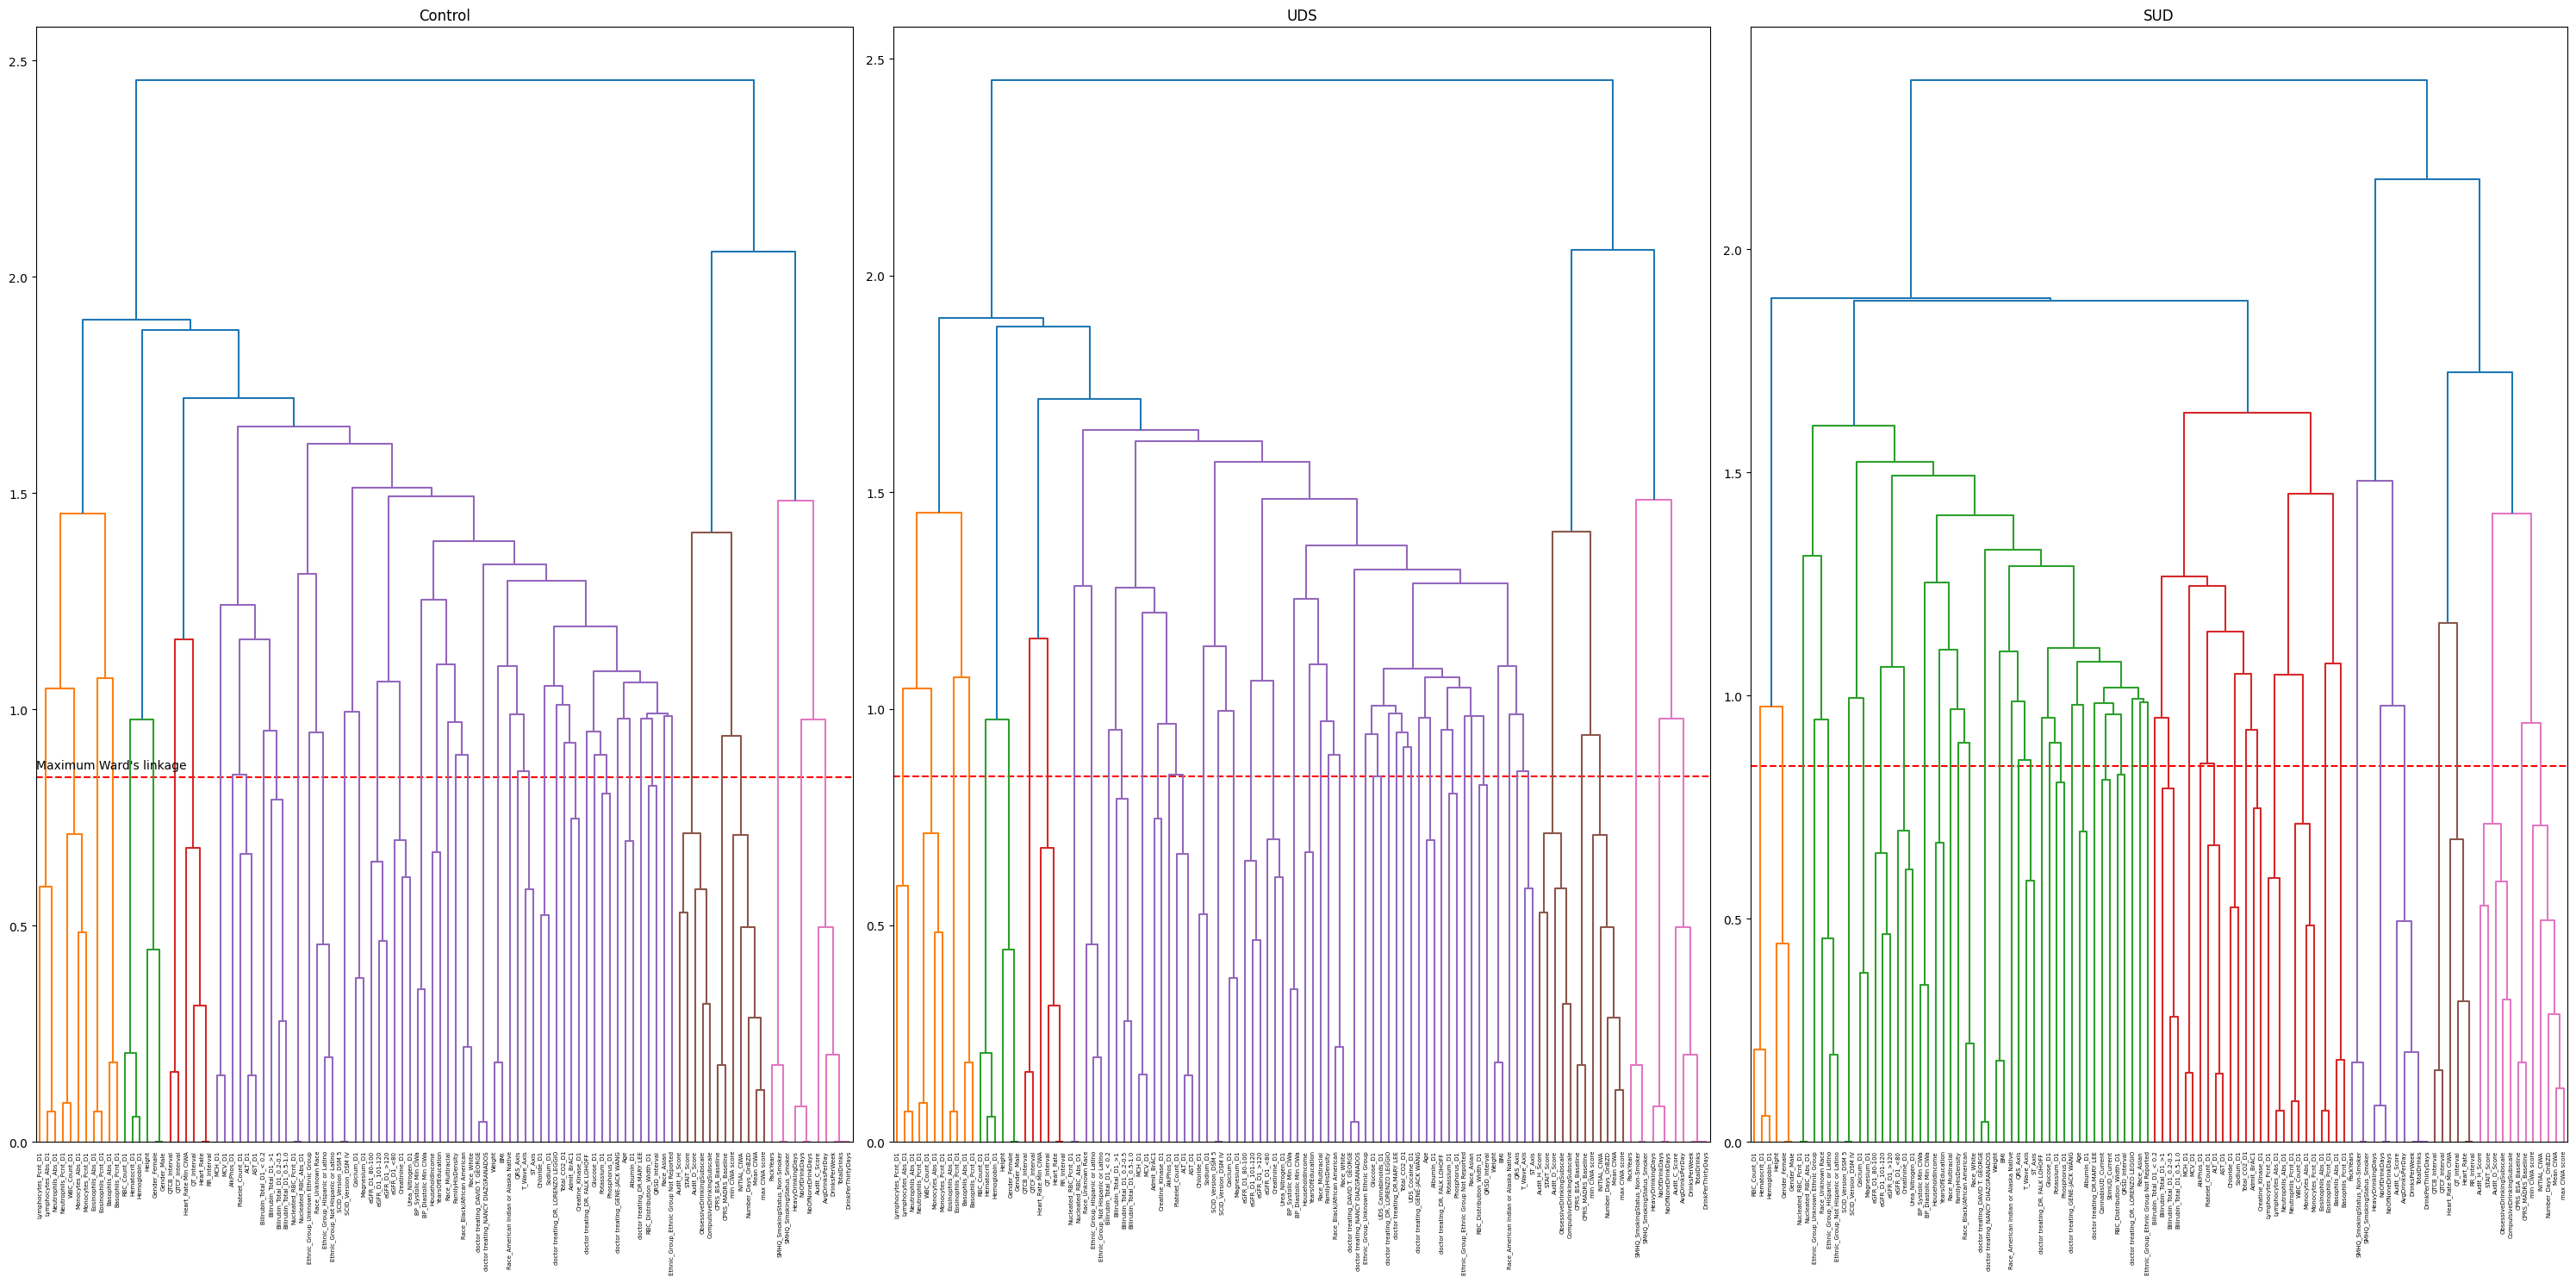

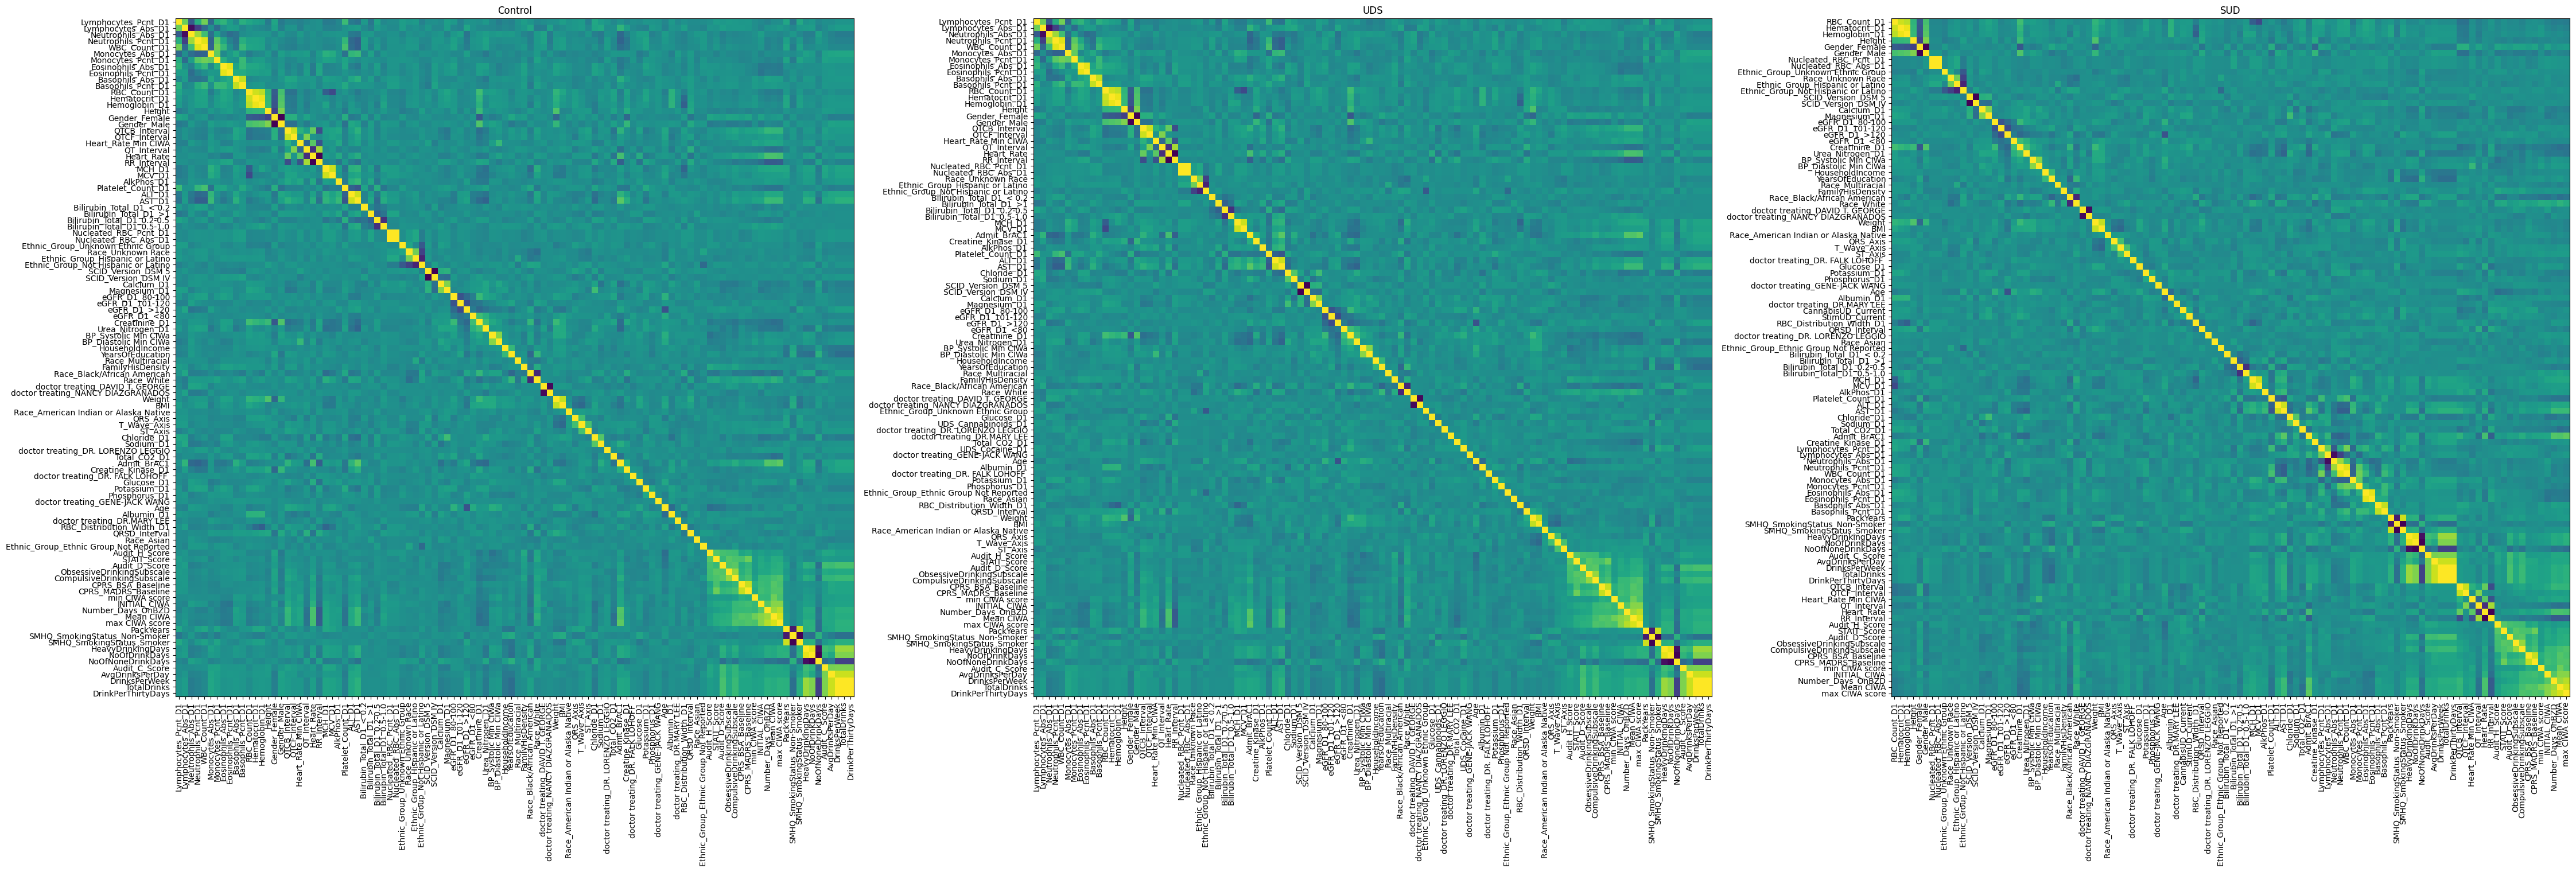

In [9]:
#Dendrogram and Spearman's rank correlation distance
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(30, 15))
fig2, (ax4,ax5,ax6) = plt.subplots(1,3, figsize=(45,20))

corr_Control = spearmanr(X_Control_scaled).correlation
corr_UDS = spearmanr(X_UDS_scaled).correlation
corr_SUD = spearmanr(X_SUD_scaled).correlation

corr_Control = (corr_Control + corr_Control.T) / 2
corr_UDS = (corr_UDS + corr_UDS.T) / 2
corr_SUD = (corr_SUD + corr_SUD.T) / 2

np.fill_diagonal(corr_Control, 1)
np.fill_diagonal(corr_UDS, 1)
np.fill_diagonal(corr_SUD, 1)

distance_matrix_Control = 1 - np.abs(corr_Control)
distance_matrix_UDS = 1 - np.abs(corr_UDS)
distance_matrix_SUD = 1 - np.abs(corr_SUD)

dist_linkage_Control = hierarchy.ward(squareform(distance_matrix_Control))
dist_linkage_UDS = hierarchy.ward(squareform(distance_matrix_UDS))
dist_linkage_SUD = hierarchy.ward(squareform(distance_matrix_SUD))

ax1.set_title("Control")
ax2.set_title("UDS")
ax3.set_title("SUD")

ax1.annotate("Maximum Ward's linkage", xy=(0.5, .843), xytext=(0.55, .843+.02))#Determined later
ax1.axhline(y=.843, color='r', linestyle='--')
ax2.axhline(y=.843, color='r', linestyle='--')
ax3.axhline(y=.843, color='r', linestyle='--')

ax1.set_ylim((0,2.5))
ax2.set_ylim((0,2.5))
ax3.set_ylim((0,2.5))

dendro_Control = hierarchy.dendrogram(dist_linkage_Control, labels=X_Control_scaled.columns.tolist(), ax=ax1, leaf_rotation=90)
dendro_UDS = hierarchy.dendrogram(dist_linkage_UDS, labels=X_UDS_scaled.columns.tolist(), ax=ax2, leaf_rotation=90)
dendro_SUD = hierarchy.dendrogram(dist_linkage_SUD, labels=X_SUD_scaled.columns.tolist(), ax=ax3, leaf_rotation=90)

dendro_idx_Control = np.arange(0, len(dendro_Control["ivl"]))
dendro_idx_UDS = np.arange(0, len(dendro_UDS["ivl"]))
dendro_idx_SUD = np.arange(0, len(dendro_SUD["ivl"]))


ax4.set_title("Control")
ax5.set_title("UDS")
ax6.set_title("SUD")

ax4.imshow(corr_Control[dendro_Control["leaves"], :][:, dendro_Control["leaves"]])
ax5.imshow(corr_UDS[dendro_UDS["leaves"], :][:, dendro_UDS["leaves"]])
ax6.imshow(corr_SUD[dendro_SUD["leaves"], :][:, dendro_SUD["leaves"]])

ax4.set_xticks(dendro_idx_Control)
ax5.set_xticks(dendro_idx_UDS)
ax6.set_xticks(dendro_idx_SUD)

ax4.set_yticks(dendro_idx_Control)
ax5.set_yticks(dendro_idx_UDS)
ax6.set_yticks(dendro_idx_SUD)

ax4.set_xticklabels(dendro_Control["ivl"], rotation="vertical")
ax5.set_xticklabels(dendro_UDS["ivl"], rotation="vertical")
ax6.set_xticklabels(dendro_SUD["ivl"], rotation="vertical")

ax4.set_yticklabels(dendro_Control["ivl"])
ax5.set_yticklabels(dendro_UDS["ivl"])
ax6.set_yticklabels(dendro_SUD["ivl"])

fig1.tight_layout()
fig2.tight_layout()
plt.show()

Pick the Cluster Distance (Higher distance = more features per cluster, but minimizes multicollinearity). Create a dataframe with the non-clustered and clustered features. Determine the maximum Ward's linkage distance at which there are no feature differences between all compared dataframes except the UDS and SUD variables.

In [12]:
#Cluster the variables
from collections import defaultdict
from sklearn.decomposition import PCA

cluster_ids_Control = hierarchy.fcluster(dist_linkage_Control, .848, criterion="distance")
cluster_ids_UDS = hierarchy.fcluster(dist_linkage_UDS, .843, criterion="distance")
cluster_ids_SUD = hierarchy.fcluster(dist_linkage_SUD, .848, criterion="distance")

cluster_id_to_feature_ids_Control = defaultdict(list)
cluster_id_to_feature_ids_UDS = defaultdict(list)
cluster_id_to_feature_ids_SUD = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids_Control):
    cluster_id_to_feature_ids_Control[cluster_id].append(idx)
for idx, cluster_id in enumerate(cluster_ids_UDS):
    cluster_id_to_feature_ids_UDS[cluster_id].append(idx)
for idx, cluster_id in enumerate(cluster_ids_SUD):
    cluster_id_to_feature_ids_SUD[cluster_id].append(idx)

X_Control_pca = pd.DataFrame(index=X_Control_scaled.index)
X_UDS_pca = pd.DataFrame(index=X_UDS_scaled.index)
X_SUD_pca = pd.DataFrame(index=X_SUD_scaled.index)

pca_to_original_mapping = {}
for cluster_feature_indices in cluster_id_to_feature_ids_Control.values():
    grouped_features_Control = X_Control_scaled.iloc[:, cluster_feature_indices]
    pca = PCA(n_components=1)
    pca_components_Control = pca.fit_transform(grouped_features_Control)
    original_feature_names_Control = [X_Control_scaled.columns[idx] for idx in cluster_feature_indices]
    pca_to_original_mapping[pca_components_Control.flatten()[0]] = original_feature_names_Control
    X_Control_pca[", ".join(original_feature_names_Control)] = pca_components_Control.flatten()
for cluster_feature_indices in cluster_id_to_feature_ids_UDS.values():
    grouped_features_UDS = X_UDS_scaled.iloc[:, cluster_feature_indices]
    pca = PCA(n_components=1)
    pca_components_UDS = pca.fit_transform(grouped_features_UDS)
    original_feature_names_UDS = [X_UDS_scaled.columns[idx] for idx in cluster_feature_indices]
    pca_to_original_mapping[pca_components_UDS.flatten()[0]] = original_feature_names_UDS
    X_UDS_pca[", ".join(original_feature_names_UDS)] = pca_components_UDS.flatten()
for cluster_feature_indices in cluster_id_to_feature_ids_SUD.values():
    grouped_features_SUD = X_SUD_scaled.iloc[:, cluster_feature_indices]
    pca = PCA(n_components=1)
    pca_components_SUD = pca.fit_transform(grouped_features_SUD)
    original_feature_names_SUD = [X_SUD_scaled.columns[idx] for idx in cluster_feature_indices]
    pca_to_original_mapping[pca_components_SUD.flatten()[0]] = original_feature_names_SUD
    X_SUD_pca[", ".join(original_feature_names_SUD)] = pca_components_SUD.flatten()
columns_Control = set(X_Control_pca.columns)
columns_UDS = set(X_UDS_pca.columns)
columns_SUD = set(X_SUD_pca.columns)

# Find the differences between the column sets
different_columns_UDS_SUD = columns_UDS.symmetric_difference(columns_SUD)
different_columns_UDS_Control = columns_UDS.symmetric_difference(columns_Control)
different_columns_SUD_Control = columns_SUD.symmetric_difference(columns_Control)

print("Columns different between UDS and SUD:", different_columns_UDS_SUD)
print("Columns different between UDS and Control:", different_columns_UDS_Control)
print("Columns different between SUD and Control:", different_columns_SUD_Control)

Columns different between UDS and SUD: {'UDS_Cannabinoids_D1', 'UDS_Cocaine_D1', 'CannabisUD_Current, StimUD_Current'}
Columns different between UDS and Control: {'UDS_Cannabinoids_D1', 'UDS_Cocaine_D1'}
Columns different between SUD and Control: {'CannabisUD_Current, StimUD_Current'}


In [14]:
#Align the dataframes
common_columns = list(set(X_Control_pca.columns) & set(X_UDS_pca.columns) & set(X_SUD_pca.columns))
X_Control_aligned = X_Control_pca[common_columns]
X_UDS_aligned = X_UDS_pca[common_columns]
X_SUD_aligned = X_SUD_pca[common_columns]

In [ ]:
#Rename the clusters (+: PCA Component)
new_column_names = {
    'Weight, BMI': 'Heaviness+',
    'Audit_H_Score, Audit_D_Score, ObsessiveDrinkingSubscale, CompulsiveDrinkingSubscale, STAIT_Score': 'Drinking Behavior & Anxiety+',
    'Hematocrit_D1, Hemoglobin_D1, RBC_Count_D1': 'Hematocrit, Hemoglobin, RBC Count+',
    'RBC_Distribution_Width_D1, QRSD_Interval': 'RBC Distribution Width & QRSD Interval+',
    'Monocytes_Abs_D1, Monocytes_Pcnt_D1, Neutrophils_Pcnt_D1, WBC_Count_D1': 'Monocytes, Neutrophil %, & WBC Count+',
    'Race_Black/African American, Race_White': 'Race: Black/African-American & White+',
    'T_Wave_Axis, ST_Axis': 'T-wave & ST axes+',
    'Heart_Rate, QT_Interval, RR_Interval, Heart_Rate Min CIWA': 'Heart Rate & QT/RR intervals+',
    'Nucleated_RBC_Pcnt_D1, Nucleated_RBC_Abs_D1': 'Nucleated RBCs+',
    'Admit_BrAC1, Creatine_Kinase_D1': 'Alcohol at Admission+',
    'Bilirubin_Total_D1_0.2-0.5, Bilirubin_Total_D1_0.5-1.0, Bilirubin_Total_D1_>1': 'Bilirubin > 0.2+',
    'Eosinophils_Abs_D1, Eosinophils_Pcnt_D1': 'Eosinophils+',
    'Calcium_D1, Magnesium_D1': 'Calcium & Magnesium+',
    'eGFR_D1_101-120, eGFR_D1_80-100, eGFR_D1_>120': 'eGFR > 80+',
    'Gender_Female, Gender_Male, Height': 'Gender & Height+',
    'eGFR_D1_<80, Creatinine_D1, Urea_Nitrogen_D1': 'eGFR < 80, Creatinine, & Urea+',
    'Race_Unknown Race, Ethnic_Group_Hispanic or Latino, Ethnic_Group_Not Hispanic or Latino': 'Hispanic, Latino/a, & Unknown Race+',
    'Lymphocytes_Abs_D1, Lymphocytes_Pcnt_D1, Neutrophils_Abs_D1': 'Lymphocytes & Absolute Neutrophils+',
    'INITIAL_CIWA, Number_Days_OnBZD, min CIWA score, Mean CIWA, max CIWA score': 'Withdrawal Severity+',
    'SMHQ_SmokingStatus_Non-Smoker, SMHQ_SmokingStatus_Smoker, PackYears': 'Smoking+',
    'ALT_D1, AST_D1, Platelet_Count_D1': 'Liver Function & Platelets+',
    'MCH_D1, MCV_D1': 'MCH & MCV+',
    'HouseholdIncome, YearsOfEducation': 'SES+',
    'NoOfDrinkDays, NoOfNoneDrinkDays, HeavyDrinkingDays': 'Binge Drinking Pattern+',
    'Age, Albumin_D1': 'Age & Albumin+',
    'SCID_Version_DSM 5, SCID_Version_DSM IV': 'SCID Version+',
    'CPRS_BSA_Baseline, CPRS_MADRS_Baseline': 'Pain Rating+',
    'Basophils_Abs_D1, Basophils_Pcnt_D1': 'Basophils+',
    'Chloride_D1, Sodium_D1': 'Chloride & Sodium+',
    'BP_Systolic Min CIWa, BP_Diastolic Min CIWa': 'Baseline Blood Pressure+',
    'doctor treating_DAVID T. GEORGE, doctor treating_NANCY DIAZGRANADOS': 'High-Volume Physicians+',
    'Potassium_D1, Phosphorus_D1': 'Potassium & Phosphorus+',
    'QTCB_Interval, QTCF_Interval': 'QTc Intervals+',
    'TotalDrinks, AvgDrinksPerDay, DrinkPerThirtyDays, DrinksPerWeek, Audit_C_Score': 'Alcohol Consumption Metrics+',
    'QRS_Axis': 'QRS Axis',
    'FamilyHisDensity': 'Family History Density of Alcohol Use',
    'Race_Asian': 'Race: Asian',
    'doctor treating_DR. FALK LOHOFF ': 'Dr. Falk Lohoff',
    'AlkPhos_D1': 'Alkaline Phosphatase',
    'Race_Multiracial': 'Race: Multi-racial',
    'Total_CO2_D1': 'Blood CO2',
    'doctor treating_DR.MARY LEE': 'Dr. Mary Lee',
    'Bilirubin_Total_D1_< 0.2': 'Bilirubin < 0.2',
    'Ethnic_Group_Unknown Ethnic Group': 'Unknown Ethnic Group',
    'Ethnic_Group_Ethnic Group Not Reported': 'Ethnic Group Not Reported',
    'doctor treating_DR. LORENZO LEGGIO': 'Dr. Lorenzo Leggio',
    'doctor treating_GENE-JACK WANG': 'Dr. Gene-Jack Wang',
    'Glucose_D1': 'Glucose',
    'Race_American Indian or Alaska Native': 'Race: American Indian or Alaska Native'
}

X_Control_aligned.rename(columns=new_column_names, inplace=True)
X_UDS_aligned.rename(columns=new_column_names, inplace=True)
X_SUD_aligned.rename(columns=new_column_names, inplace=True)
X_Control_aligned

In [18]:
#Find permutation importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
X_UDS_aligned_UDS = X_UDS_aligned.join(X_UDS_pca["UDS_Cannabinoids_D1"]).join(X_UDS_pca["UDS_Cocaine_D1"])
X_SUD_aligned_SUD = X_SUD_aligned.join(X_SUD_pca["CannabisUD_Current, StimUD_Current"])
model = Ridge(random_state = 3)
gridsearch = GridSearchCV(model, param_grid = {"alpha":[1, 5, 10, 20, 50, 100, 1000]}, scoring = 'neg_mean_absolute_error')
#model = RandomForestRegressor(random_state = 0)
#gridsearch = GridSearchCV(model, param_grid = {"n_estimators":[10, 50, 100], "max_depth": [3,5,7], "max_features":[4,8,13]})

gridsearch.fit(X_Control_aligned, y)
result_Control = permutation_importance(gridsearch, X_Control_aligned, y, n_repeats=100, random_state=42)
gridsearch.fit(X_UDS_aligned_UDS, y)
result_UDS = permutation_importance(gridsearch, X_UDS_aligned_UDS, y, n_repeats=100, random_state=42)
gridsearch.fit(X_SUD_aligned_SUD, y)
result_SUD = permutation_importance(gridsearch, X_SUD_aligned_SUD, y, n_repeats=100, random_state=42)

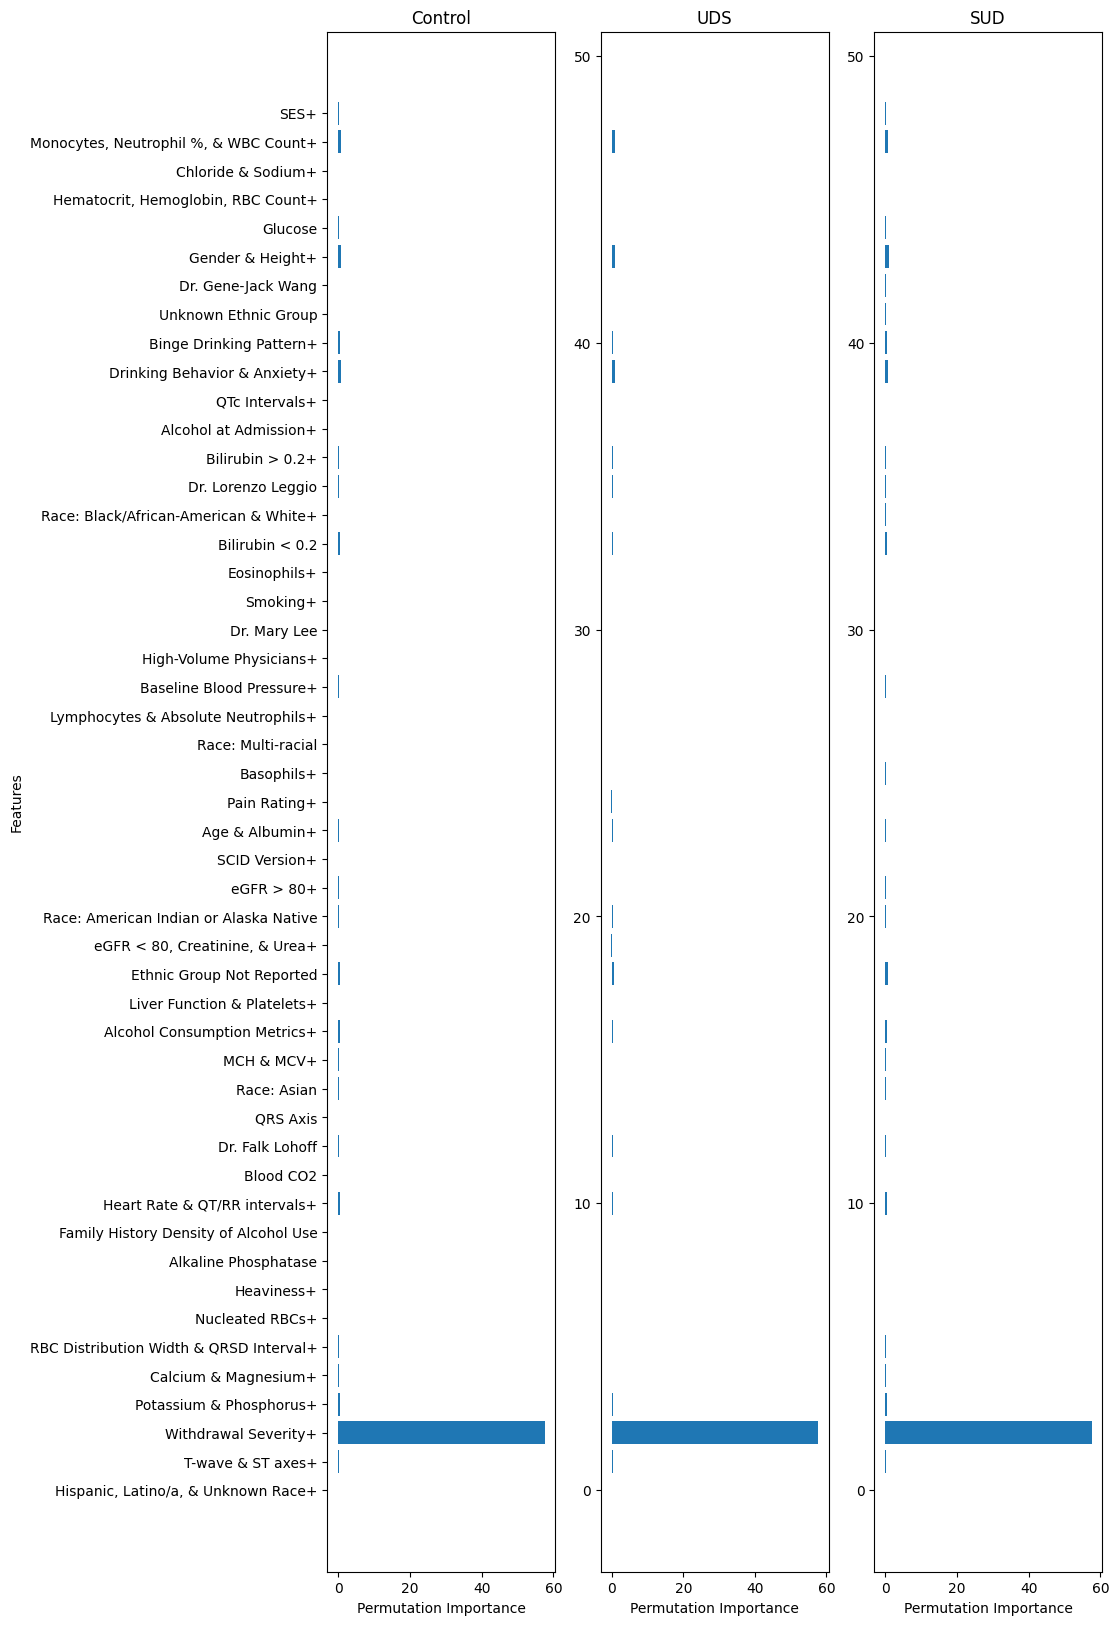

In [19]:
#Visualize permutation importance
sorted_indices_Control = result_Control.importances_mean.argsort()
sorted_indices_UDS = result_UDS.importances_mean.argsort()
sorted_indices_SUD = result_SUD.importances_mean.argsort()

sorted_importances_Control = result_Control.importances_mean[sorted_indices_Control]
sorted_importances_UDS = result_UDS.importances_mean[sorted_indices_Control]
sorted_importances_SUD = result_SUD.importances_mean[sorted_indices_Control]

sorted_feature_names_Control = [str(idx) for idx in sorted_indices_Control]
sorted_feature_names_UDS = [str(idx) for idx in sorted_indices_UDS]
sorted_feature_names_SUD = [str(idx) for idx in sorted_indices_SUD]

fig1, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,20))

ax1.barh(sorted_indices_Control, sorted_importances_Control)
ax2.barh(sorted_indices_Control, sorted_importances_UDS)
ax3.barh(sorted_indices_Control, sorted_importances_SUD)

ax1.set_yticks(range(0, len(sorted_feature_names_Control)), X_Control_aligned.columns)

ax1.set_xlabel('Permutation Importance')
ax2.set_xlabel('Permutation Importance')
ax3.set_xlabel('Permutation Importance')

ax1.set_ylabel('Features')

ax1.set_title('Control')
ax2.set_title('UDS')
ax3.set_title('SUD')

plt.show()

In [ ]:
#Compare permutation importances
from scipy.stats import ttest_rel
t_stat_UDS_Control = []
p_value_UDS_Control = []
t_stat_SUD_Control = []
p_value_SUD_Control = []
t_stat_SUD_UDS = []
p_value_SUD_UDS = []
if np.array_equal(result_UDS.importances, result_SUD.importances):
        print(f"Sample - importances_UDS and importances_SUD are equal!")

for sample_index in range(result_Control.importances.shape[0]):
    importances_Control = result_Control.importances[sample_index, :]
    importances_UDS = result_UDS.importances[sample_index, :]
    importances_SUD = result_SUD.importances[sample_index, :]

    t_stat_UDS, p_value_UDS = ttest_rel(importances_UDS, importances_Control, alternative = "less")
    t_stat_UDS_Control.append(t_stat_UDS)
    p_value_UDS_Control.append(p_value_UDS)
    t_stat_SUD, p_value_SUD = ttest_rel(importances_SUD, importances_Control, alternative = "less")
    t_stat_SUD_Control.append(t_stat_SUD)
    p_value_SUD_Control.append(p_value_SUD)
    t_stat_SUDUDS, p_value_SUDUDS = ttest_rel(importances_SUD, importances_UDS, alternative = "two-sided")
    t_stat_SUD_UDS.append(t_stat_SUDUDS)
    p_value_SUD_UDS.append(p_value_SUDUDS)
    print(f"Sample {sample_index}: p-value = {p_value_UDS, p_value_SUD, p_value_SUDUDS}")

Sample 0: p-value = (0.5695414602947202, 8.573263913918402e-10, 8.74318567845203e-06)
Sample 1: p-value = (3.963011933221675e-09, 1.8093105944139809e-06, 3.488645375226367e-07)
Sample 2: p-value = (1.3823404415070663e-28, 6.321696754759732e-05, 8.491445579476716e-31)
Sample 3: p-value = (0.9819532448821734, 1.635176189369872e-09, 9.297195195925345e-10)
Sample 4: p-value = (0.00031357289152735257, 0.00609215008545174, 0.004013610379215819)
Sample 5: p-value = (1.604443206140006e-32, 1.6633859605398997e-21, 2.9242796445465215e-26)
Sample 6: p-value = (1.3511562151839587e-44, 4.781810465858712e-35, 4.3902518012222224e-27)
Sample 7: p-value = (0.9999997560340887, 0.9761559648567641, 4.281634870058527e-06)
Sample 8: p-value = (7.701282769354545e-08, 1.4691590567899782e-15, 0.055180970507985976)
Sample 9: p-value = (1.0, 1.0, 8.996252451101602e-25)
Sample 10: p-value = (5.255112964814327e-07, 1.508865703089527e-23, 0.000938862395375907)
Sample 11: p-value = (0.6655093992138652, 2.50367983288

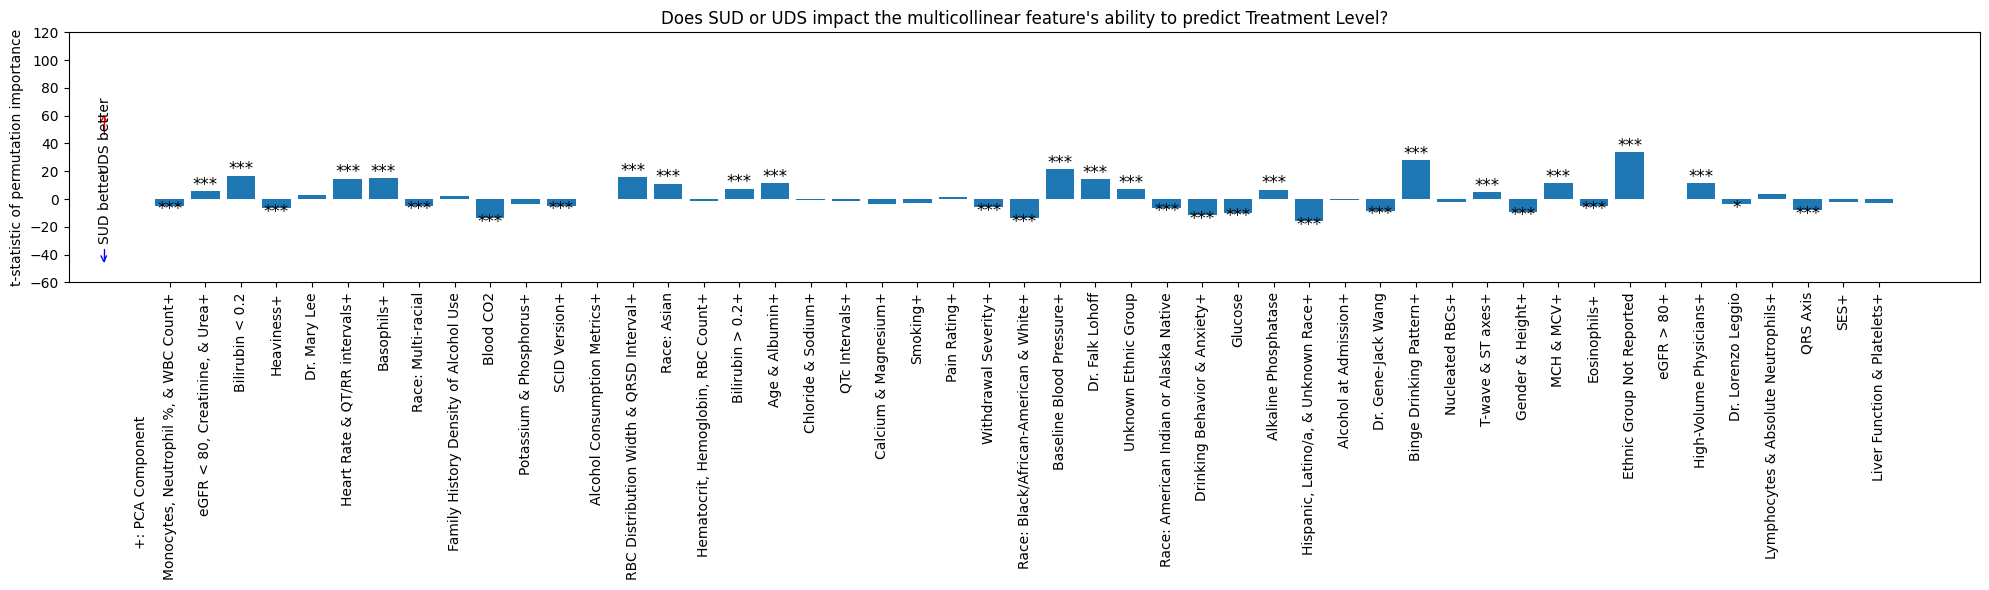

In [ ]:
#Visualize permutation importance differences
plt.figure(figsize=(20, 6))
plt.bar(range(len(p_value_SUD_UDS)), t_stat_SUD_UDS)
plt.xticks(range(len(p_value_SUD_UDS)), X_Control_aligned.columns, rotation=90)
plt.ylabel('t-statistic of permutation importance')
plt.title("Does SUD or UDS impact the multicollinear feature's ability to predict Treatment Level?")
plt.ylim(-60,120)
plt.tight_layout()

arrow_props_up = dict(facecolor='red', edgecolor='red', arrowstyle='->', connectionstyle='angle,angleA=0,angleB=90,rad=0')
arrow_props_down = dict(facecolor='blue', edgecolor='blue', arrowstyle='->', connectionstyle='angle,angleA=00,angleB=270,rad=0')
plt.annotate('UDS better', xy=(-1.85, 63), xytext=(-2, 20),
            arrowprops=arrow_props_up, rotation = 90)
plt.annotate('SUD better', xy=(-1.85, -48), xytext=(-2, -30),
            arrowprops=arrow_props_down, rotation = 90)
plt.annotate('+: PCA Component', xy=(0, 0), xytext=(-1, -250), rotation = 90)
for i, bar in enumerate(p_value_SUD_UDS):
    p_value = p_value_SUD_UDS[i]
    t_stat = t_stat_SUD_UDS[i]
    if p_value < 0.00001:
        asterisks = '***'
    elif p_value < 0.0001:
        asterisks = '**'
    elif p_value < 0.0005:
        asterisks = '*'
    else:
        asterisks = ''
    if t_stat > 0:
      plt.text(i, t_stat+1, asterisks, ha='center',  fontsize=12)
    elif t_stat < 0:
      plt.text(i, t_stat-6, asterisks, ha='center',  fontsize=12)
plt.show()

5
10
15
20
25
50
80
100
300
400
500
700
800
1000


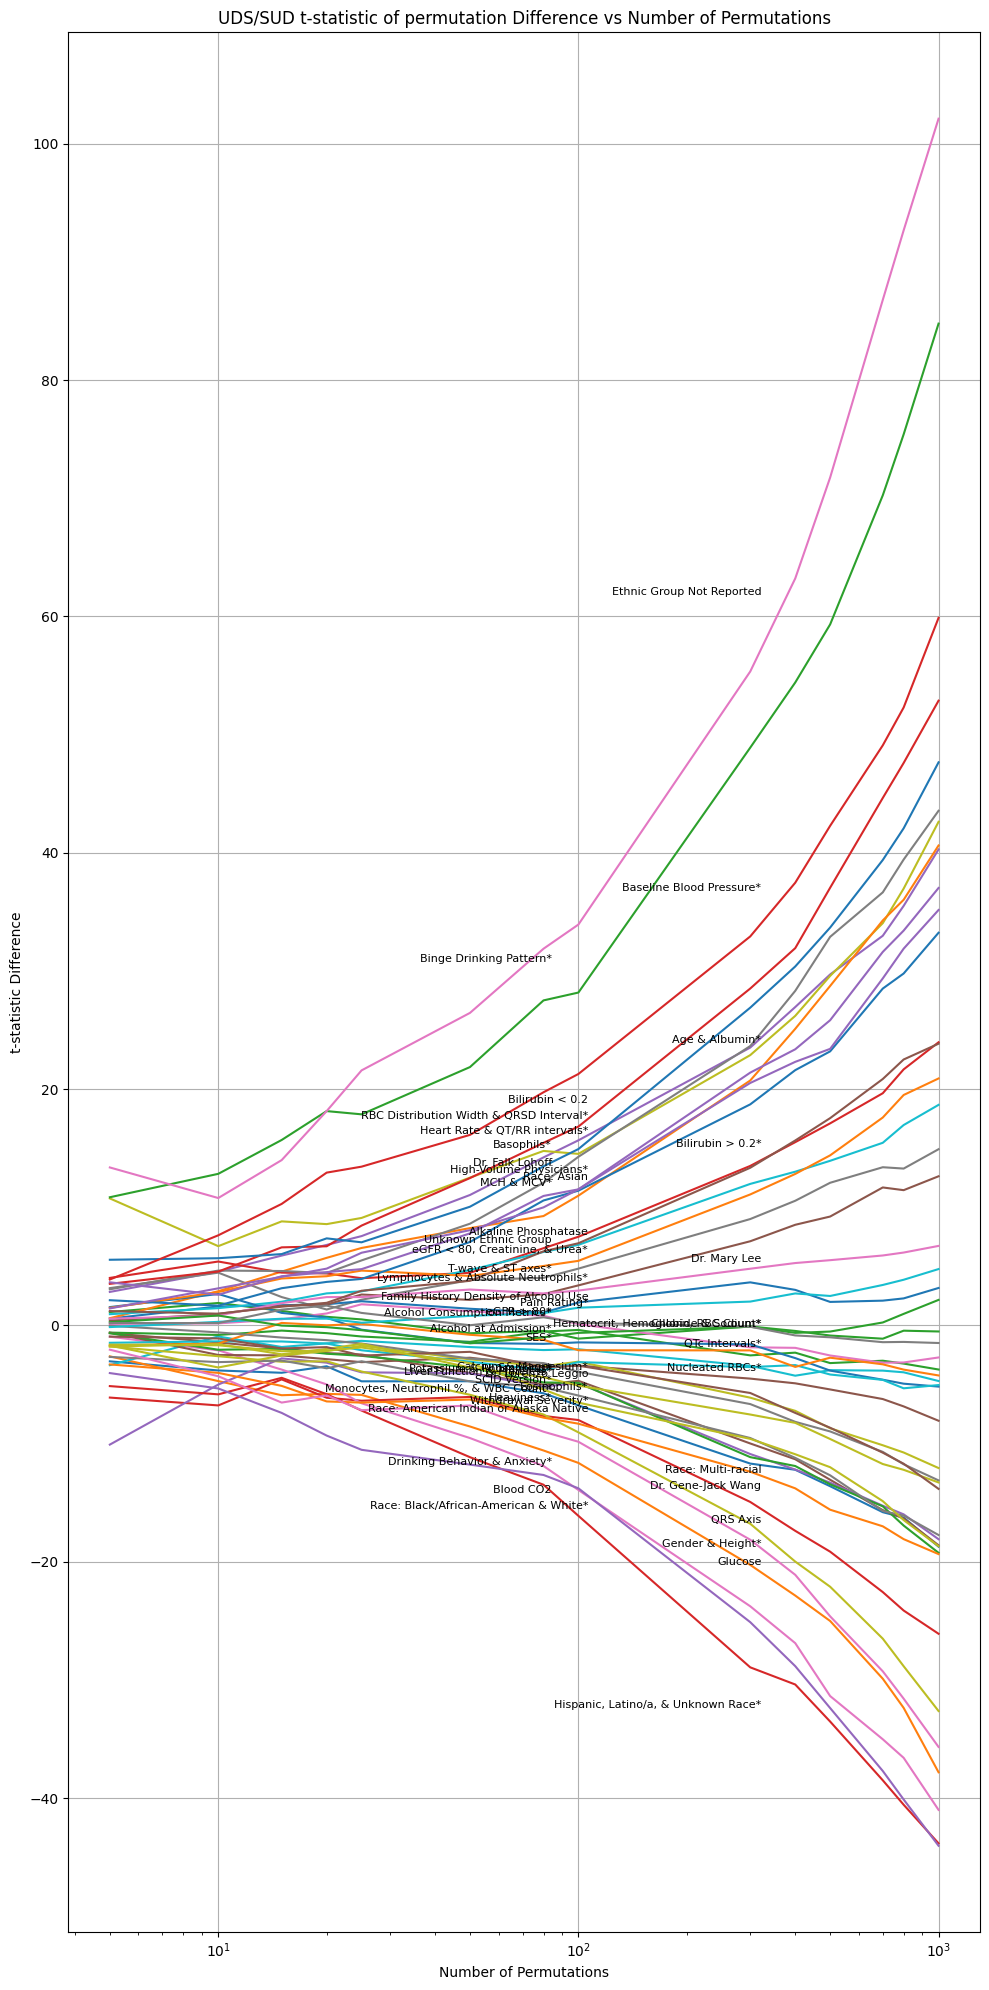

In [ ]:
#Visualize permutation importance differences as number of permutations increase
import random
num_permutations_list = [5,10,15,20,25,50,80,100,300,400,500,700,800,1000]
t_stat_UDS_Control_per_feature = []
t_stat_SUD_Control_per_feature = []
t_stat_SUD_UDS_per_feature = []

for num_permutations in num_permutations_list:
    gridsearch.fit(X_UDS_aligned_UDS, y)
    result_UDS = permutation_importance(gridsearch, X_UDS_aligned_UDS, y, n_repeats=num_permutations, random_state=42)
    gridsearch.fit(X_Control_aligned, y)
    result_Control = permutation_importance(gridsearch, X_Control_aligned, y, n_repeats=num_permutations, random_state=42)
    gridsearch.fit(X_SUD_aligned_SUD, y)
    result_SUD = permutation_importance(gridsearch, X_SUD_aligned_SUD, y, n_repeats=num_permutations, random_state=42)
    t_stat_UDS_Control = []
    t_stat_SUD_Control = []
    t_stat_SUD_UDS = []
    print(num_permutations)
    for sample_index in range(result_Control.importances.shape[0]):
        importances_Control = result_Control.importances[sample_index, :]
        importances_UDS = result_UDS.importances[sample_index, :]
        importances_SUD = result_SUD.importances[sample_index, :]

        t_stat_UDS, _ = ttest_rel(importances_UDS, importances_Control, alternative="less")
        t_stat_SUD, _ = ttest_rel(importances_SUD, importances_Control, alternative="less")
        t_stat_SUDUDS, _ = ttest_rel(importances_SUD, importances_UDS, alternative = "two-sided")
        t_stat_UDS_Control.append(t_stat_UDS)
        t_stat_SUD_Control.append(t_stat_SUD)
        t_stat_SUD_UDS.append(t_stat_SUDUDS)

    t_stat_UDS_Control_per_feature.append(t_stat_UDS_Control)
    t_stat_SUD_Control_per_feature.append(t_stat_SUD_Control)
    t_stat_SUD_UDS_per_feature.append(t_stat_SUD_UDS)
t_stat_UDS_Control_per_feature = np.array(t_stat_UDS_Control_per_feature)
t_stat_SUD_Control_per_feature = np.array(t_stat_SUD_Control_per_feature)
t_stat_SUD_UDS_per_feature = np.array(t_stat_SUD_UDS_per_feature)
plt.figure(figsize=(10, 20))
feature_names = X_Control_aligned.columns
for feature_idx in range(t_stat_UDS_Control_per_feature.shape[1]):
    selected_x = random.choice(num_permutations_list[6:9])
    x_index = num_permutations_list.index(selected_x)
    selected_feature_y = t_stat_SUD_UDS_per_feature[x_index, feature_idx]
    plt.plot(num_permutations_list, t_stat_SUD_UDS_per_feature[:, feature_idx], label=feature_names[feature_idx])
    plt.annotate(feature_names[feature_idx],
                 xy=(selected_x,selected_feature_y),
                 textcoords='offset points',
                 xytext=(x_index, selected_feature_y), fontsize = 8,
                 ha='right')
plt.xlabel('Number of Permutations')
plt.ylabel('t-statistic Difference')
plt.xscale('log')
plt.title('UDS/SUD t-statistic of permutation Difference vs Number of Permutations')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
#Establish definitive direction of permutation importance change
import scipy.stats
correlation_results = {}
for feature_idx, t_statistic in enumerate(t_stat_SUD_UDS_per_feature.T):
    correlation_coefficient, p_value = scipy.stats.pearsonr(num_permutations_list, t_statistic)
    correlation_results[feature_names[feature_idx]] = {
        'correlation': correlation_coefficient,
        'p_value': p_value
    }

# Print the correlation coefficients and p-values for each feature
for feature, result in correlation_results.items():
    print(f"{feature}: {result['correlation']:.4f} {result['p_value']:.4f}")

Heaviness*: -0.9764 0.0000
Drinking Behavior & Anxiety*: -0.9826 0.0000
Hematocrit, Hemoglobin, RBC Count*: -0.5559 0.0390
QRS Axis: -0.9841 0.0000
RBC Distribution Width & QRSD Interval*: 0.9626 0.0000
Monocytes, Neutrophil %, & WBC Count*: -0.9785 0.0000
Race: Black/African-American & White*: -0.9621 0.0000
T-wave & ST axes*: 0.9594 0.0000
Heart Rate & QT/RR intervals*: 0.9864 0.0000
Nucleated RBCs*: -0.8427 0.0002
Family History Density of Alcohol Use: 0.5888 0.0267
Race: Asian: 0.9794 0.0000
Alcohol at Admission*: -0.9329 0.0000
Bilirubin > 0.2*: 0.9833 0.0000
Eosinophils*: -0.9297 0.0000
Calcium & Magnesium*: -0.9564 0.0000
eGFR > 80*: -0.9028 0.0000
Dr. Falk Lohoff: 0.9727 0.0000
Gender & Height*: -0.9824 0.0000
Alkaline Phosphatase: 0.9541 0.0000
QTc Intervals*: -0.8956 0.0000
eGFR < 80, Creatinine, & Urea*: 0.9853 0.0000
Race: Multi-racial: -0.9760 0.0000
Hispanic, Latino/a, & Unknown Race*: -0.9596 0.0000
Blood CO2: -0.9765 0.0000
Lymphocytes & Absolute Neutrophils*: 0.9713 0.

In [ ]:
#Compare MAE with increasing variance of secondary explanatory variables
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
cv = LeaveOneOut()
errors_UDS = []
errors_SUD = []
errors_Control = []
pca = PCA(n_components = 107)
X_Control_pca = pca.fit_transform(X_Control)
for i in range(1,95):
  X_UDS_pca = np.hstack((X_Control_pca[:,0:i], X_UDS_CIWA5))
  X_SUD_pca = np.hstack((X_Control_pca[:,0:i], X_SUD_CIWA5))
  scores_UDS = pd.DataFrame(-cross_val_score(gridsearch, X_UDS_pca, y_CIWA5, cv = cv, scoring = 'neg_mean_absolute_error'))
  scores_SUD = pd.DataFrame(-cross_val_score(gridsearch, X_SUD_pca, y_CIWA5, cv = cv, scoring = 'neg_mean_absolute_error'))
  scores_Control = pd.DataFrame(-cross_val_score(gridsearch, X_Control_pca[:,0:i], y_CIWA5, cv = cv, scoring = 'neg_mean_absolute_error'))
  errors_UDS.append(scores_UDS)
  errors_SUD.append(scores_SUD)
  errors_Control.append(scores_Control)
  print(f"{i} components:", sum(pca.explained_variance_ratio_[:i]))
errors_SUD = pd.DataFrame(np.concatenate(errors_SUD,1))
errors_UDS = pd.DataFrame(np.concatenate(errors_UDS,1))
errors_Control = pd.DataFrame(np.concatenate(errors_Control,1))

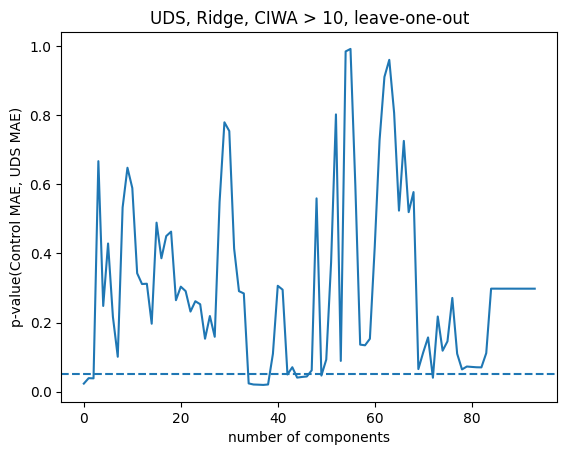

In [ ]:
#Visualize MAE change vs. increasing variance of secondary explanatory variables
plt.plot(range(94),p_value_UDS_Control)
plt.xlabel("number of components")
plt.ylabel("p-value(Control MAE, UDS MAE)")
plt.title("UDS, Ridge, CIWA > 10, leave-one-out")
plt.axhline(y = .05, linestyle = '--')